# Decision Tree Classifier 

In [68]:
# importing python libraries
import matplotlib as mpl
import numpy as np 
from math import log
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import random
import math

In [69]:
# Randomizing original data
df = pd.read_csv("../dataset/data.csv")
df_vis = df
df = df.apply(np.random.permutation)

In [70]:
# reading train data from dataset

df1 = df.head(8990)
mapping_dept = {}
mapping_sal = {}
mapping_dept["accounting"] = 1
mapping_dept["hr"] = 2
mapping_dept["IT"] = 3
mapping_dept["management"] = 4
mapping_dept["marketing"] = 10
mapping_dept["product_mng"] = 5
mapping_dept["RandD"] = 6
mapping_dept["sales"] = 7
mapping_dept["support"] = 8
mapping_dept["technical"] = 9

mapping_sal["low"] = 1
mapping_sal["medium"] = 2
mapping_sal["high"] = 3
dfh = df1.applymap(lambda s: mapping_dept.get(s) if s in mapping_dept else s)
dfh1 = dfh.applymap(lambda s: mapping_sal.get(s) if s in mapping_sal else s)
dfh2 = dfh1.drop(df.columns[[6]],axis=1,inplace=False) 
dfh3 = pd.DataFrame(dfh1["left"]) 
df3 = pd.concat([dfh2,dfh3],axis=1)
train_data = df3.iloc[:,0:10].values
train_data_categ = df3.iloc[:,5:10].values


df_vish = df_vis.applymap(lambda s: mapping_dept.get(s) if s in mapping_dept else s)
df_vish1 = df_vish.applymap(lambda s: mapping_sal.get(s) if s in mapping_sal else s)
df_vish2 = df_vish1.drop(df_vis.columns[[6]],axis=1,inplace=False)
df_vish3 = pd.DataFrame(df_vish1["left"])
df_vis3 = pd.concat([df_vish2,df_vish3],axis=1)
df_vis = df_vis3.iloc[:,0:10].values

In [71]:
class decNode:
  # decision tree nodes, each node storing tb, fb, col(parameter of splitting), value(parameter's value) 
  # and results(0s and 1s denoting whether the employee has not left or left)
  decisionnd = 0
  def __init__(self, col = -1, value = None, results = None, tb = None, fb = None): 
    if tb == None:
      self.tb = None
    else:
      self.tb = tb

    if fb == None:
      self.fb = None
    else:
      self.fb = fb
    
    self.col = col

    if value == None:
      self.value = None
    else:
      self.value = value

    self.results = results    

In [72]:
def dividedata(rows,column,value):
  # dividing data on basis of value ( making branches on a node)
  st1 = []
  st2 = []

  sfunc = None

  flag = type(value)
  if not isinstance(value,int) and not isinstance(value,float):
    sfunc = lambda row:row[column] == value          
  else:
    sfunc = lambda row:row[column] >= value          
  
  
  for row in rows:
    if sfunc(row):
      st1.append(row)
  for row in rows:
    if not sfunc(row):
      st2.append(row)
  
  temp = (st1,st2)
  return temp

In [73]:
def getuniquecnt(rows):
  # number of 1s and 0s in job_left column
  ans = {}
  for row in rows:
    job_left = len(row) - 1
    val = row[job_left]
    if val not in ans: 
      ans[val] = 0
      ans[val] = ans[val] + 1
    else:
      ans[val] = ans[val] + 1
  return ans

In [74]:
def giniimpurity(data):
  # calculating gini impurity function
  gimp = 0
  job_left = getuniquecnt(data)
  
  for k1 in job_left:
    p1 = float(job_left[k1])/len(data)
      
    for k2 in job_left:
      if k1 != k2: 
        p2 = float(job_left[k2])/len(data)
        gimp = gimp + p1 * p2
  return gimp

In [75]:
def log2(x):
    # calculating log2(x)
    return log(x)/log(2)

In [76]:
def entropy(data):
   # this function gets the entropy of the data
   job_left = getuniquecnt(data)       
   ent = 0.0
   rec = len(data)
   for r in job_left.keys():          
      p = float(job_left[r]) / rec
      ent = ent - p * log2(p)
   return ent

In [77]:
def buildtree(data):
  # Building the decision tree using entropy, max information gain
  # Here I am dividing the data in all possible combination of each attribute and I am picking that attribute
  # which has max information gain
  records = len(data)
  best_gain = 0.0
  best_criteria = None
  best_sets = None
  
  if records == 0: 
    return decNode()
  current_score = entropy(data)

  
  column_count = len(data[0]) - 1
  for col in range(0,column_count):
    cv = {}                   
    for row in data:
      r1 = row[col]
      cv[r1] = 1
    for value in cv.keys():
      (set1,set2) = dividedata(data, col, value)
      l1 = len(set1)
      l2 = len(set2)
      p = float(l1) / records
      gain = current_score - p * entropy(set1) - (1-p) * entropy(set2)
      if gain > best_gain and l1 > 0 and l2 > 0:
        best_criteria = (col, value)
        best_sets = (set1, set2)
        best_gain = gain

  if best_gain > 0:
    cr1 = best_criteria[0]
    cr2 = best_criteria[1]
    trueBranch = buildtree(best_sets[0])  
    falseBranch = buildtree(best_sets[1])
    return decNode(col = cr1, value = cr2, tb = trueBranch, fb = falseBranch)
  else:
    job_left = getuniquecnt(data)
    return decNode(results = job_left)

In [78]:
def buildtree_gini(data):
  # Building the decision tree using gini impurity
  records = len(data)
  if records == 0: 
    return decNode()
  best_gain = 0.0
  current_score = giniimpurity(data)
  best_criteria = None
  best_sets = None
  
  column_count = len(data[0]) - 1
  for col in range(0,column_count):
    cv = {}                   
    for row in data:
      r1 = row[col]
      cv[r1] = 1
    for value in cv.keys():
      (set1,set2) = dividedata(data,col,value)
      l1 = len(set1)
      l2 = len(set2)
      p = float(l1) / records
      gain = current_score - p * giniimpurity(set1) - (1-p) * giniimpurity(set2)
      if gain > best_gain and l1 > 0 and l2 > 0:
        best_gain = gain
        best_criteria = (col, value)
        best_sets = (set1, set2)
  if best_gain > 0:
    cr1 = best_criteria[0]
    cr2 = best_criteria[1]  
    trueBranch = buildtree_gini(best_sets[0])  
    falseBranch = buildtree_gini(best_sets[1])
    return decNode(col = cr1, value = cr2, tb = trueBranch, fb = falseBranch)
  else:
    job_left = getuniquecnt(data)
    return decNode(results = job_left)


In [79]:
def buildtree_misclassification_rate(data):
  # Building the decision tree using misclassification rate
  records = len(data)
  if records == 0: 
    return decNode()
  best_gain = 0.0
  best_criteria = None
  best_sets = None

  column_count = len(data[0])-1
  for col in range(0,column_count):
    cv = {}                   
    for row in data:
      r1 = row[col]
      cv[r1] = 1
    for value in cv.keys():
      (set1,set2) = dividedata(data, col, value)
      l1 = len(set1)
      l2 = len(set2)
      p = float(l1) / records
      gain = 1 - max(p, 1-p)
      if gain > best_gain and l1 > 0 and l2 > 0:
        best_criteria = (col, value)
        best_sets = (set1, set2)
        best_gain = gain

  if best_gain > 0:
    cr1 = best_criteria[0]
    cr2 = best_criteria[1] 
    trueBranch = buildtree_misclassification_rate(best_sets[0])  
    falseBranch = buildtree_misclassification_rate(best_sets[1])  
    return decNode(col = cr1, value = cr2, tb = trueBranch, fb = falseBranch)
  else:
    job_left = getuniquecnt(data)
    return decNode(results = job_left)

In [80]:
def classify(observation,tree):
  # classifying the observation given into whether the employee would be leaving or not
  if tree.results == None:
    branch = None
    if isinstance(observation[tree.col],int) or isinstance(observation[tree.col],float):
      if observation[tree.col] >= tree.value: 
        branch = tree.tb
      else: 
        branch = tree.fb
    else:
      if observation[tree.col] != tree.value: 
        branch = tree.fb
      else: 
        branch = tree.tb
    return classify(observation,branch)
  else:
    return tree.results


In [81]:
def readtestdata():
  # reading test data
  df2 = pd.read_csv("../dataset/testdata.csv")
  mapping_dept = {}
  mapping_dept["accounting"] = 1
  mapping_dept["hr"] = 2
  mapping_dept["IT"] = 3
  mapping_dept["management"] = 4
  mapping_dept["marketing"] = 10
  mapping_dept["product_mng"] = 5
  mapping_dept["RandD"] = 6
  mapping_dept["sales"] = 7
  mapping_dept["support"] = 8
  mapping_dept["technical"] = 9

  mapping_sal["low"] = 1
  mapping_sal["medium"] = 2
  mapping_sal["high"] = 3
  dfh = df2.applymap(lambda s: mapping_dept.get(s) if s in mapping_dept else s)
  dhf1 = dfh.applymap(lambda s: mapping_sal.get(s) if s in mapping_sal else s)
  dt = dhf1.iloc[:,0:10].values
  return dt

In [82]:
def readvalidatedata(isCategorical):
    # splitting the original data into validate data (20%) and reading it
    df3 = df.tail(2248)
    mapping_dept = {}
    mapping_dept["accounting"] = 1
    mapping_dept["hr"] = 2
    mapping_dept["IT"] = 3
    mapping_dept["management"] = 4
    mapping_dept["marketing"] = 10
    mapping_dept["product_mng"] = 5
    mapping_dept["RandD"] = 6
    mapping_dept["sales"] = 7
    mapping_dept["support"] = 8
    mapping_dept["technical"] = 9

    mapping_sal["low"] = 1
    mapping_sal["medium"] = 2
    mapping_sal["high"] = 3
    dfh = df.applymap(lambda s: mapping_dept.get(s) if s in mapping_dept else s)
    dfh1 = dfh.applymap(lambda s: mapping_sal.get(s) if s in mapping_sal else s)
    dfh2 = dfh1.drop(df.columns[[6]],axis=1,inplace=False) 
    dfh3 = pd.DataFrame(dfh1["left"]) 
    df3 = pd.concat([dfh2, dfh3],axis=1)
    ind = 0
    if isCategorical == 1:
        ind = 5
    validate_data = df3.iloc[:,ind:10].values
    return validate_data

In [83]:
def measures(data,tree,isCategorical):
    # Calculatiion of precision, recall, f1 score and accuracy
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(data)):
        observation = data[i,:]
        results = classify(observation,tree)
        actual = observation[4]
        if isCategorical == 0:
            actual = observation[9]
        predicted = 0
        if 1 in results.keys():
            predicted = 1
        
        if isCategorical == 1:
            val = 0
            if 0 in results.keys():
                if val < results[0] * df3["left"].mean():
                    predicted = 0
                    val = results[0] * df3["left"].mean()
            if 1 in results.keys():
                if val < results[1] * (1 - df3["left"].mean()):
                    predicted = 1
                    val = results[1] * (1 - df3["left"].mean())
        
        if(actual == 1 and predicted == 1):
            tp = tp + 1
        if(actual == 1 and predicted == 0):
            fn = fn + 1
        if(actual == 0 and predicted == 0):
            tn = tn + 1
        if(actual == 0 and predicted == 1):
            fp = fp + 1
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 / (1 / recall + 1 / precision)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print("Precision: ",precision)
    print("Recall:    ",recall)
    print("F1 Score:  ",f1_score)
    print("Accuracy:  ",accuracy)

In [84]:
def error(data,tree):
    ## Calculationg error in classifying dataset
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(data)):
        observation = data[i,:]
        results = classify(observation,tree)
        actual = observation[9]
        predicted = 0
        if 1 in results.keys():
            predicted = 1
        if(actual == 1 and predicted == 1):
            tp = tp + 1
        if(actual == 1 and predicted == 0):
            fn = fn + 1
        if(actual == 0 and predicted == 0):
            tn = tn + 1
        if(actual == 0 and predicted == 1):
            fp = fp + 1
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    error = 1 - accuracy
    
    return error

## Part 1

In [109]:
def split(data, index):
    unique_cls = set([row[index] for row in data])
    groups = {}
    for itr in unique_cls:
        s1 = str(itr)
        groups[s1] = []
    for itr in unique_cls:
        s1 = str(itr)
        for row in data:
            if(row[index] == itr):
                groups[s1].append(row)
    return groups

In [110]:
def split_nodes(dataset):
    
    column_values = len(dataset[0]) - 1
    start = 5
    id1 = None
    branches = None
    val = -math.inf
    for idx in range(start, column_values):
        avg = 0
        groups = split(dataset, idx)
        for group in groups:
            l1 = len(groups[group])
            l2 = len(dataset)
            avg = avg + (l1/l2) * entropy(groups[group])
        info_gain = entropy(dataset) - avg

        if(info_gain > val):
            id1 = idx
            branches = groups
            val = info_gain
    dictt = { 'index': id1, 'groups': branches, 'gain': val }
    return dictt

In [111]:
def buildcateg_tree(node):
    node['ans'] = {}
    node['children'] = {}
    groups = node['groups']
    del(node['groups'])
    for group in groups:
        val = node['gain']
        if not groups[group]:
            node['ans'][group] = random.randint(-1, 1) < 0 and 0 or 1
        elif val == 0:
            outcomes = []
            outcomes = [row[-1] for row in groups[group]]
            v1 = set(outcomes)
            v2 = outcomes.count
            node['ans'][group] = max(set(outcomes), key = outcomes.count)
        else:
            a1 = groups[group]
            node['children'][group] = split_nodes(a1)
            buildcateg_tree(node['children'][group])

In [112]:
def predictor(node, row):
    if not node['children']:
        v1 = node['ans'].get(str(row[node['index']]))
        if v1 == None:
            n = random.randint(-1, 1) < 0 and 0 or 1
            return n
        return node['ans'][str(row[node['index']])]
    
    v2 = node['children'].get(str(row[node['index']]))
    if v2 is None:
        v1 = node['ans'].get(str(row[node['index']]))
        if v1 is None:
            n = random.randint(-1, 1) < 0 and 0 or 1
            return n
        str1 = str(row[node['index']])
        return node['ans'][str1]
    str1 = str(row[node['index']])
    return predictor(node['children'][str1], row)

In [113]:
def measures_categorical(root, validate_data):
    # Calculatiion of precision, recall, f1 score and accuracy
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for row in validate_data:
        predicted = predictor(root,row)
        actual = row[9]
        val = predicted == actual
        if val == 1:
            if actual == 0 and predicted == 0:
                tn = tn + 1
            else:
                tp = tp + 1
        else:
            if actual == 1 and predicted == 1:
                fn = fn + 1
            else:
                fp = fp + 1
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 / (1 / recall + 1 / precision)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print("Precision: ",precision)
    print("Recall:    ",recall)
    print("F1 Score:  ",f1_score)
    print("Accuracy:  ",accuracy)

In [115]:
cat = pd.read_csv("../dataset/data.csv")
cat = cat.apply(np.random.permutation)

tmp1 = cat.head(8990)
tmp2 = cat.tail(11238-8990)
tmp = pd.DataFrame(tmp1["left"]) 
categorical_data = tmp1.drop(cat.columns[[6]],axis=1,inplace=False)
valid_categorical = tmp2.drop(cat.columns[[6]],axis=1,inplace=False)


categorical_data = pd.concat([categorical_data,tmp],axis=1)
categorical_data = categorical_data.iloc[:,0:10].values

tmp = pd.DataFrame(tmp2["left"]) 
valid_categorical = pd.concat([valid_categorical,tmp],axis=1)
valid_categorical = valid_categorical.iloc[:,0:10].values

for i in range(len(categorical_data)):
    for j in range(len(categorical_data[i])):
        categorical_data[i][j]=str(categorical_data[i][j])
for i in range(len(valid_categorical)):
    for j in range(len(valid_categorical[i])):
        valid_categorical[i][j]=str(valid_categorical[i][j])
        
root = split_nodes(categorical_data)
buildcateg_tree(root)
measures_categorical(root, valid_categorical)


Precision:  0.7606761565836299
Recall:     1.0
F1 Score:   0.8640727640222333
Accuracy:   0.7606761565836299


## Part 2

In [104]:
train_tree_non_categorical = buildtree(train_data)
validate_data = readvalidatedata(0)
measures(validate_data,train_tree_non_categorical,0)

Precision:  0.8418913926856298
Recall:     0.8519626168224299
F1 Score:   0.8468970642883685
Accuracy:   0.9266773447232604


## Part 3

### Using Misclassification Rate

In [381]:
train_tree_non_categorical = buildtree_misclassification_rate(train_data)
validate_data = readvalidatedata(0)
measures(validate_data,train_tree_non_categorical,0)

Precision:  0.8525084873632591
Recall:     0.8448598130841122
F1 Score:   0.8486669170108899
Accuracy:   0.9282790532123154


### Using Gini Impurity

In [382]:
train_tree_non_categorical = buildtree_gini(train_data)
validate_data = readvalidatedata(0)
measures(validate_data,train_tree_non_categorical,0)

Precision:  0.8393382352941177
Recall:     0.8534579439252337
F1 Score:   0.846339202965709
Accuracy:   0.9262324256985228


### Using Entropy measure

In [383]:
train_tree_non_categorical = buildtree(train_data)
validate_data = readvalidatedata(0)
measures(validate_data,train_tree_non_categorical,0)

Precision:  0.8338809784592918
Recall:     0.8538317757009346
F1 Score:   0.8437384558551904
Accuracy:   0.9247197010144154


## Part 4

### Satisfaction level vs last Evaluation

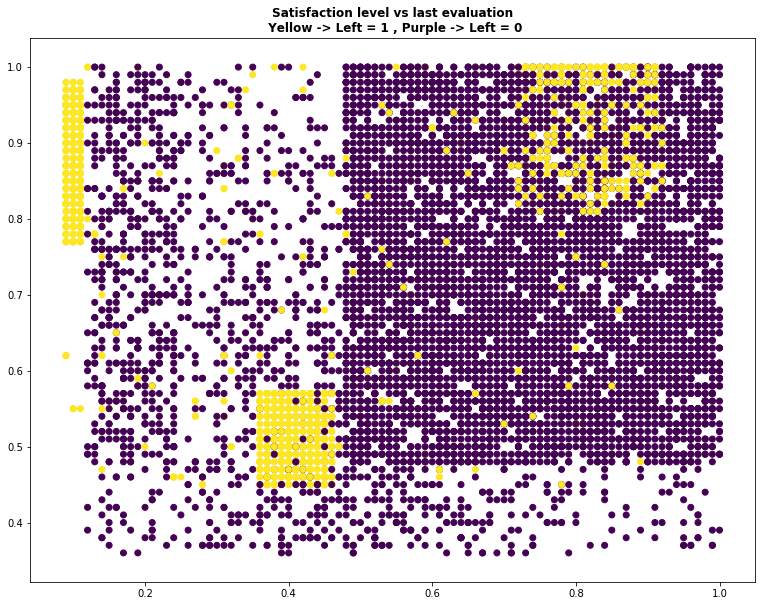

In [384]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(df_vis[:,0], df_vis[:,1], c = df_vis[:,9], alpha = 1)
plt.title("Satisfaction level vs last evaluation\n Yellow -> Left = 1 , Purple -> Left = 0",fontweight="bold")
plt.show()

### Satisfaction level vs Promotion Last 5 years

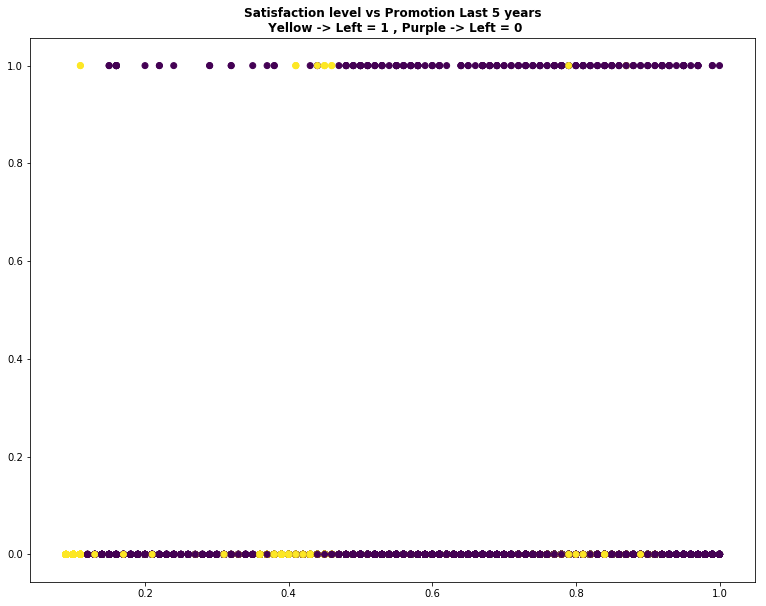

In [385]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(df_vis[:,0], df_vis[:,6], c = df_vis[:,9], alpha = 1)
plt.title("Satisfaction level vs Promotion Last 5 years\n Yellow -> Left = 1 , Purple -> Left = 0",fontweight="bold")
plt.show()

### Satisfaction level vs average_montly_hours


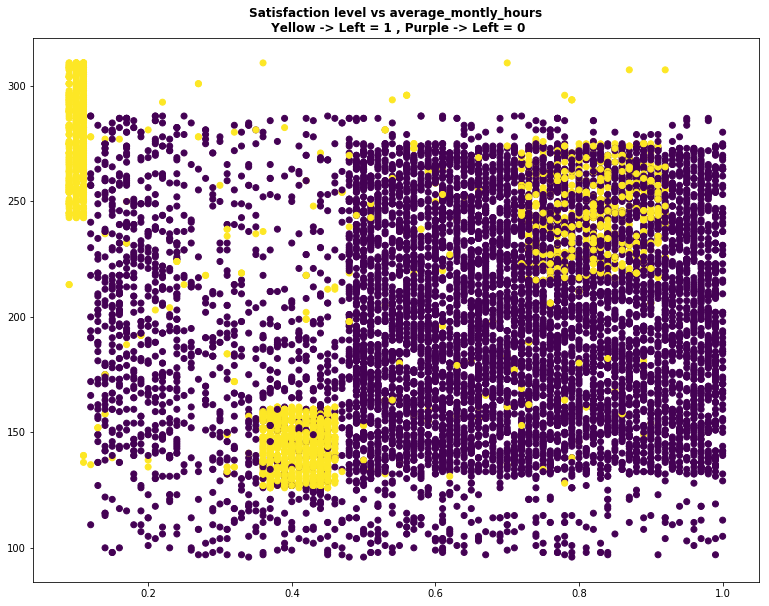

In [386]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(df_vis[:,0], df_vis[:,3], c = df_vis[:,9], alpha = 1)
plt.title("Satisfaction level vs average_montly_hours\n Yellow -> Left = 1 , Purple -> Left = 0",fontweight="bold")
plt.show()

## Part 5

In [138]:
def buildtreedepth(data,isCategorical,depth,maxdepth):
  records = len(data)
  best_gain = 0.0
  best_criteria = None
  best_sets = None
  if records == 0: 
    return decNode()
  if depth == maxdepth:
    job_left = getuniquecnt(data)
    return decNode(results = job_left)
  current_score = entropy(data)

  
  column_count = len(data[0]) - 1
  start = 0
  if(isCategorical == 1):
    start = 5
  for col in range(start,column_count):
    cv={}                   
    for row in data:
      r1 = row[col]
      cv[r1] = 1
    for value in cv.keys():
      (set1,set2) = dividedata(data,col,value)
      l1 = len(set1)
      l2 = len(set2)
      p = float(l1) / records
      gain = current_score - p * entropy(set1) - (1-p) * entropy(set2)
      if gain > best_gain and l1 > 0 and l2 > 0:
        best_criteria = (col, value)
        best_sets = (set1, set2)
        best_gain = gain
  if best_gain > 0:
    cr1 = best_criteria[0]
    cr2 = best_criteria[1]
    trueBranch = buildtreedepth(best_sets[0], isCategorical, depth + 1, maxdepth)  
    falseBranch = buildtreedepth(best_sets[1],isCategorical, depth + 1, maxdepth)
    return decNode(col = cr1, value = cr2, tb = trueBranch, fb = falseBranch)
  else:
    job_left = getuniquecnt(data)
    return decNode(results = job_left)

In [142]:
depth = [i for i in range(1,41)]
errors_validation = []
validate_data = readvalidatedata(0)
for i in range(len(depth)):
    tempTree = buildtreedepth(train_data,0,0,depth[i])
    errors_validation.append(error(validate_data,tempTree))

In [188]:
depth = [i for i in range(1,41)]
errors_training = []
for i in range(len(depth)):
    tempTree = buildtreedepth(train_data,0,0,depth[i])
    errors_training.append(error(train_data,tempTree))

Text(0, 0.5, 'Error')

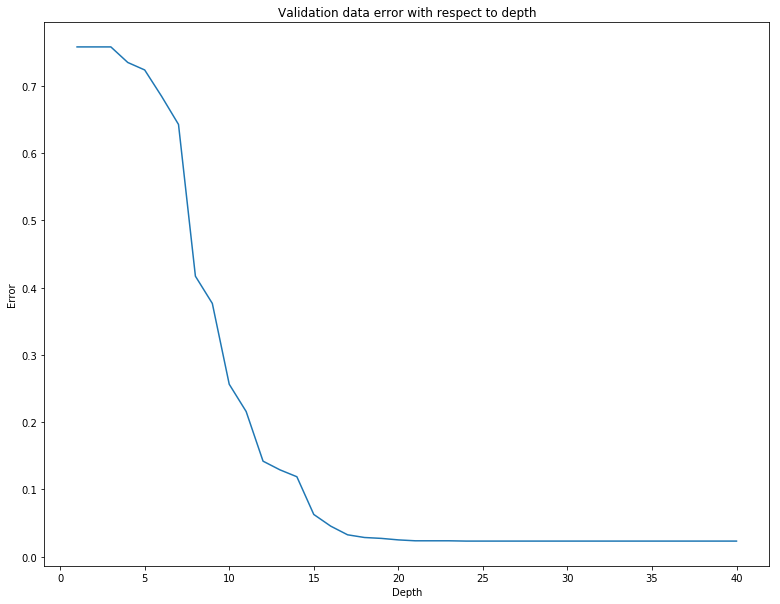

In [184]:
plt.plot(depth,errors_validation)
plt.title("Validation data error with respect to depth")
plt.xlabel("Depth",)
plt.ylabel("Error")

Text(0, 0.5, 'Error')

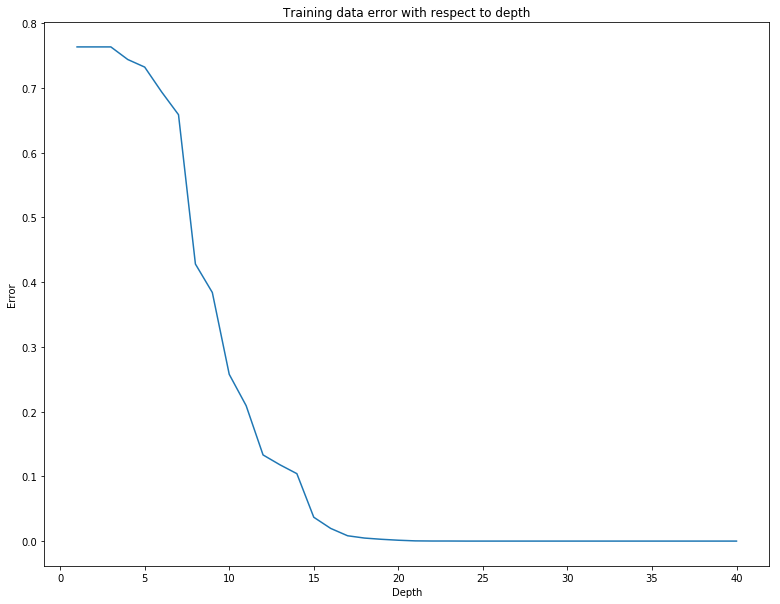

In [189]:
plt.plot(depth,errors_training)
plt.title("Training data error with respect to depth")
plt.xlabel("Depth",)
plt.ylabel("Error")

## Part 6

There are several methods used by various decision trees. We can simply ignore the missing values or treating the missing values as another category are not real handling missing values. 

The real handling approaches to missing data does not use data point with missing values in the evaluation of a split. However, when child nodes are created and trained, those instances are distributed somehow.

The following approaches to distribute the missing value instances to child nodes:

1. All goes to the node which already has the biggest number of instances (CART, is not the primary rule)
distribute to all children, but with diminished weights, proportional with the number of instances from each child node (C45 and others)
2. Distribute randomly to only one single child node, eventually according with a categorical distribution (I have seen that in various implementations of C45 and CART for a faster running time)
3. Build, sort and use surrogates to distribute instances to a child node, where surrogates are input features which resembles best how the test feature send data instances to left or right child node (CART, if that fails, the majority rule is used)


In [105]:
def predict(observation, model):
    # model -> categorical or non categorical
    # observation -> data row which we have to predict
    a = classify(observation,model)
    if 1 in a.keys():
        return "YES"
    else:
        return "NO"

In [106]:
model = buildtree(train_data)
obser = readtestdata()

In [108]:
obser = readtestdata()
predict(obser[0],model)

'NO'